In [2]:
import os, sys
import h5py

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import iqr

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
%matplotlib inline

from matplotlib.colors import LogNorm, SymLogNorm
plt.rcParams['image.cmap'] = 'terrain_r'

import geom

sys.path.append('..')
from sprmodel import SprFitSet

In [3]:
basedir = "../data"
geom_fname = os.path.join(basedir, "agipd_taw9_oy2_1050addu_hmg5.geom")
geom_xy = geom.pixel_maps_from_geometry_file(geom_fname)

modules = (3, 4, 14, 15)

eV = 1.6021766208e-19
hc = 6.6260700400E-34 * 299792458

L = 5.465
lx = 200e-6
ly = 200e-6
Eph = 9200


lmd = hc / Eph / eV
lmd *= 1e10
lmd2 = lmd*lmd


In [4]:
CsI = type("CsI", (), {"rho": 4.51, "Mr": 259.809, "Ne": 108, "f": 108.})
IrCl3 = type("IrCl3", (), {"rho": 5.3, "Mr": 298.58, "Ne": 128, "f": 123.6})
HOH = type("HOH", (), {"rho": 1, "Mr": 18.01, "Ne": 10, "f": 10.04})
n = 1
IrCl3nW = type("IrCl3", (), {"rho": IrCl3.rho, 
                             "Mr": IrCl3.Mr + n*HOH.Mr, 
                             "Ne": IrCl3.Ne + n*HOH.Ne,
                             "f": IrCl3.f + n*HOH.f})

asf_k = .6022140857

asf = lambda M: M.rho * asf_k * M.f / M.Mr

print("Atomic scattering factor:")
print("CsI: {} IrCl3: {} IrCl3.{}(H20): {}".format(asf(CsI), asf(IrCl3), n, asf(IrCl3nW)))
print((asf(IrCl3nW)/asf(CsI)))


Atomic scattering factor:
CsI: 1.1290079899570684 IrCl3: 1.3212485875154263 IrCl3.1(H20): 1.347305408220804
1.193353297944363


In [5]:
# runs

grp_list = (
    (0, list(range(171, 182))),
    (0, list(range(184, 188))),
    (0, list(range(301, 314))),
    (0, list(range(314, 318))),
    #(1, [328, 329, 332, 339]),
    #(1, list(range(354, 359)))
)

run = type("run", (), {"i": [], "g": [], "s": []})
for i in range(len(grp_list)):
    j, r = grp_list[i]
    nr = len(r)
    run.i += r
    run.g += [i] * nr
    run.s += [j] * nr
    
asfs = [asf(IrCl3nW), asf(IrCl3nW)]



fits = SprFitSet([lx, ly], L, 6)
fits.read(run, asfs, os.path.join(basedir, "fits/fit_spr_r{:04d}.h5"), 1.09)


 run file                             Nfit   Nhit Rf/h,% Ncell      Imx
0171 ../data/fits/fit_spr_r0171.h5     458   3014   15.2    30     0.67
0172 ../data/fits/fit_spr_r0172.h5     395   2494   15.8    30     0.63
0173 ../data/fits/fit_spr_r0173.h5     560   3413   16.4    30     0.87
0174 ../data/fits/fit_spr_r0174.h5     588   3636   16.2    30     0.69
0175 ../data/fits/fit_spr_r0175.h5     727   4496   16.2    30     0.61
0176 ../data/fits/fit_spr_r0176.h5     572   2958   19.3    30     0.63
0177 ../data/fits/fit_spr_r0177.h5     645   3866   16.7    30     0.58
0178 ../data/fits/fit_spr_r0178.h5     530   3002   17.7    30     0.59
0179 ../data/fits/fit_spr_r0179.h5     745   4452   16.7    30     0.75
0180 ../data/fits/fit_spr_r0180.h5     723   4081   17.7    30     0.62
0181 ../data/fits/fit_spr_r0181.h5     634   3870   16.4    30     0.65
0184 ../data/fits/fit_spr_r0184.h5    1354   8479   16.0    30     0.61
0185 ../data/fits/fit_spr_r0185.h5    1639  10073   16.3    30  

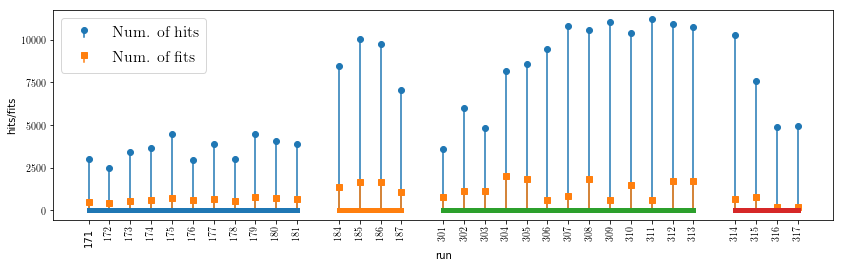

In [6]:
fig = plt.figure(figsize=(12, 4))
ax = fig.gca()
fits.plot_n_by_run((fits.nhit, fits.nfit), ("Num. of hits", "Num. of fits"), ax=ax)
ax.set_ylabel("hits/fits")
#ax.legend(("Num. of hits", "Num. of fits"), loc=2)
ax.legend()
plt.tight_layout()
fig.savefig("fig_fits_1.png", dpi=300)
plt.show()

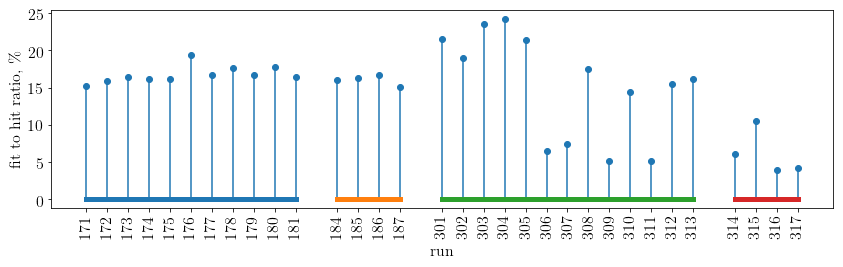

In [7]:
r = 100*np.array(fits.nfit, dtype=float) / np.array(fits.nhit, dtype=float)

fig = plt.figure(figsize=(12, 4))
ax = fig.gca()
fits.plot_n_by_run((r,), ax=ax)
ax.set_ylabel("fit to hit ratio, \%")
plt.tight_layout()
fig.savefig("fig_fits_2.png", dpi=300)
plt.show()

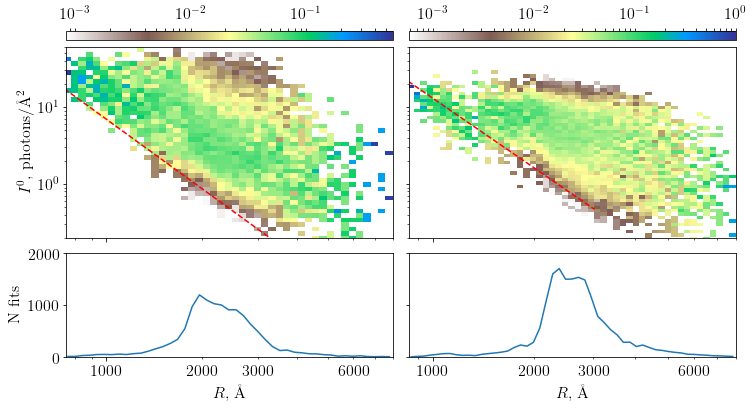

In [8]:
fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(2, 2, hspace=0.1, wspace=0.05, height_ratios=[2, 1])

# 3rd shift
k, = np.where(fits.grp < 2)

ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])


divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("top", size="5%", pad=0.1)

H, Rb, Ib = fits.get_IR_distribution(k=k, Imx=60,Rmx=8000)
hh = np.histogram(fits.P[k,3], bins=Rb)[0]
im = fits.plot_IR_distribution(Rb, Ib, H/hh, ax=ax1)
plt.colorbar(im, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position('top')

ax1.loglog(Rb[:30], 7e9 / Rb[:30]**3, 'r--')

ax1.tick_params(which='both', labelbottom=False)
ax1.set_xlabel('')
ax1.set_xlim(750,8000)
ax1.set_ylim(.2,60)


ax2.plot(0.5*(Rb[1:]+Rb[:-1]),hh)
ax2.semilogx()
ax2.set_xlabel('$R$, \AA')
ax2.set_ylabel('N fits')
ax2.set_ylim(0, 2000)
ax2.set_xlim(750,8000)
ax2.set_xticks([1000])
ax2.set_xticks([800, 900] + list(range(2000, 9000, 1000)), minor=True)
ax2.set_xticklabels(['1000'])
ax2.set_xticklabels(['', '', '2000', '3000', '','', '6000', '', ''], minor=True)



# 4th shift
k, = np.where(np.logical_and(fits.grp >= 2, fits.grp < 4))

ax3 = fig.add_subplot(grid[0, 1])
ax4 = fig.add_subplot(grid[1, 1])

divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("top", size="5%", pad=0.1)

H, Rb, Ib = fits.get_IR_distribution(k=k, Imx=30,Rmx=8000)
hh = np.histogram(fits.P[k,3], bins=Rb)[0]
im = fits.plot_IR_distribution(Rb, Ib, H/hh, ax=ax3)
plt.colorbar(im, cax=cax3, orientation='horizontal')
cax3.xaxis.set_ticks_position('top')

ax3.loglog(Rb[:30], 1.3e10 / Rb[:30]**3, 'r--')

ax3.tick_params(which='both', labelbottom=False, labelleft=False)

ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_xlim(850,8000)
ax3.set_ylim(.2,60)


ax4.plot(0.5*(Rb[1:]+Rb[:-1]),hh)
ax4.semilogx()
ax4.tick_params(which='both', labelleft=False, labelbottom=True)

ax4.set_ylabel('')
ax4.set_xlabel('$R$, \AA')
ax4.set_ylim(0, 2000)
ax4.set_xlim(850,8000)
ax4.set_xticks([1000])
ax4.set_xticks([900] + list(range(2000, 9000, 1000)), minor=True)
ax4.set_xticklabels(['1000'])
ax4.set_xticklabels(['', '2000', '3000', '','', '6000', '', ''], minor=True)


plt.savefig("fig_fits_3.png", dpi=300)
plt.show()




3rd shift
                x          y
Median     -1.682      1.402
   IQR      0.497      0.557
   90%      1.378      1.613

4th shift
                x          y
Median      3.770      1.461
   IQR      0.502      0.596
   90%      1.281      1.497


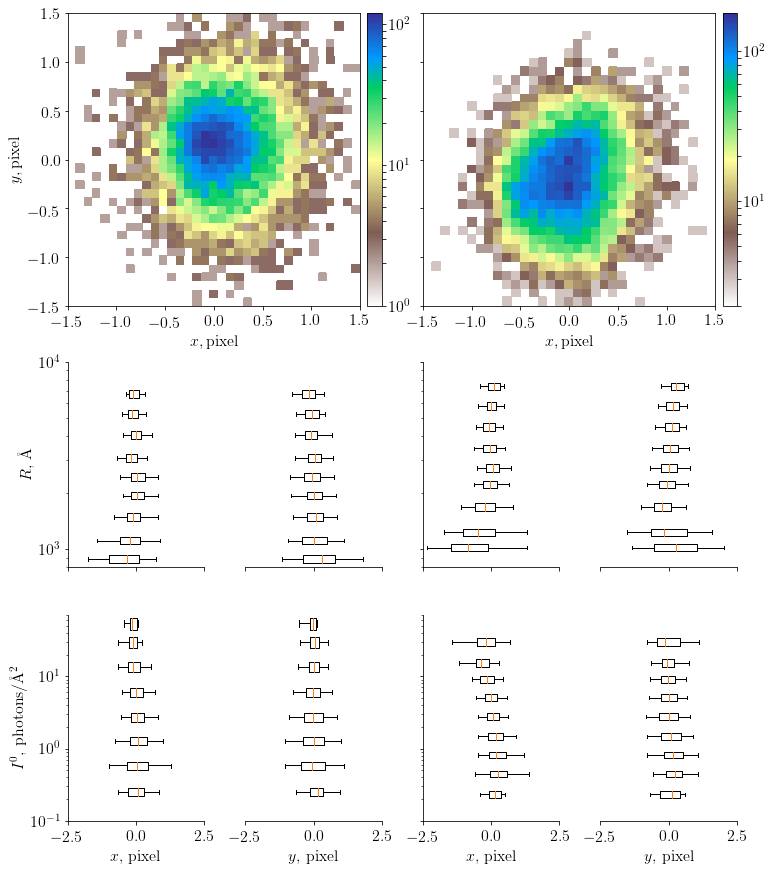

In [9]:
#fig = plt.figure(figsize=(6, 6))

fig = plt.figure(figsize=[12, 15])
gs = plt.GridSpec(3, 4, height_ratios=[3, 2, 2])
gs.update(wspace=0.3)

a0 = plt.subplot(gs[0, :2])

# 3rd shift
k1, = np.where(fits.grp < 2)
print("")
print("3rd shift")
print("                x          y")
print("Median {:10.3f} {:10.3f}".format(np.median(fits.P[k1,4]), np.median(fits.P[k1,5])))
print("   IQR {:10.3f} {:10.3f}".format(iqr(fits.P[k1,4]),iqr(fits.P[k1,5])))
print("   90% {:10.3f} {:10.3f}".format(np.percentile(fits.P[k1,4], 95)-np.percentile(fits.P[k1,4], 5),
                                       np.percentile(fits.P[k1,5], 95)-np.percentile(fits.P[k1,5], 5)))
rn = ((-1.5,1.5), (-1.5, 1.5))
H, D, x_bins, y_bins = fits.get_center_distribution(2, 'count', i=k1, d=2.5, ranges=rn)
j = H<1
H[j] = float("nan")
im=fits.plot_center_distribution((x_bins, y_bins), H, ax=a0)

ax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[2, 0]), plt.subplot(gs[2, 1])]
fits.plot_bandwidth_dist(ax, k1, (800,10000), (0.1,70), (-2.5, 2.5))

# 4th shift
a0 = plt.subplot(gs[0, 2:])

k1, = np.where(fits.grp >= 2)
print("")
print("4th shift")
print("                x          y")
print("Median {:10.3f} {:10.3f}".format(np.median(fits.P[k1,4]), np.median(fits.P[k1,5])))
print("   IQR {:10.3f} {:10.3f}".format(iqr(fits.P[k1,4]),iqr(fits.P[k1,5])))
print("   90% {:10.3f} {:10.3f}".format(np.percentile(fits.P[k1,4], 95)-np.percentile(fits.P[k1,4], 5),
                                       np.percentile(fits.P[k1,5], 95)-np.percentile(fits.P[k1,5], 5)))


rn = ((-1.5,1.5), (-1.5, 1.5))
H, D, x_bins, y_bins = fits.get_center_distribution(2, 'count', i=k1, d=3, ranges=rn)
j = H<2
H[j] = float("nan")
im=fits.plot_center_distribution((x_bins, y_bins), H, ax=a0)
a0.tick_params(labelleft=False)
a0.set_ylabel('')

ax = [plt.subplot(gs[1, 2]), plt.subplot(gs[1, 3]), plt.subplot(gs[2, 2]), plt.subplot(gs[2, 3])]
fits.plot_bandwidth_dist(ax, k1, (800,10000), (0.1,70), (-2.5, 2.5), labelleft=False)

plt.savefig("fig_fits_4.png", dpi=300)
plt.show()


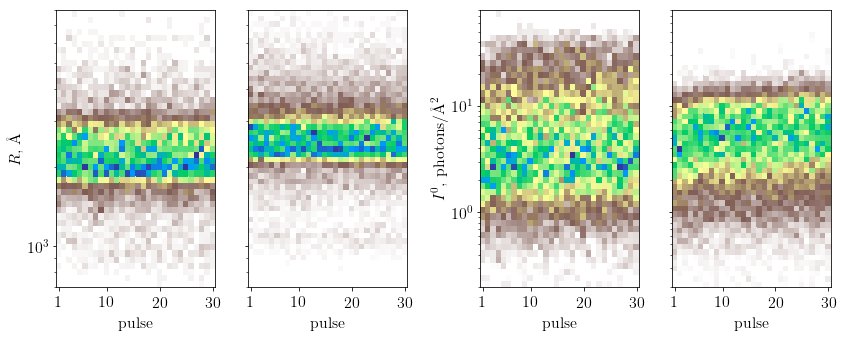

In [10]:
# histograms of size and incident photon intensity by pulses in a train
fig = plt.figure(figsize=[12, 5])
gs = plt.GridSpec(1, 2)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1])

# shifts: 3rd, 4th
k = [np.where(fits.grp < 2)[0], np.where(fits.grp >= 2)[0], ]

# size
ax = [ plt.subplot(gs0[0, 0]), plt.subplot(gs0[0, 1]) ]
fits.plot_pulse_hist(ax, 3, k, (700, 8000))

# incident photon intensity
ax = [ plt.subplot(gs1[0, 0]), plt.subplot(gs1[0, 1]) ]
fits.plot_pulse_hist(ax, 2, k, (0.2, 80))

plt.tight_layout()
fig.savefig("fig_fits_5.png", dpi=300)
plt.show()


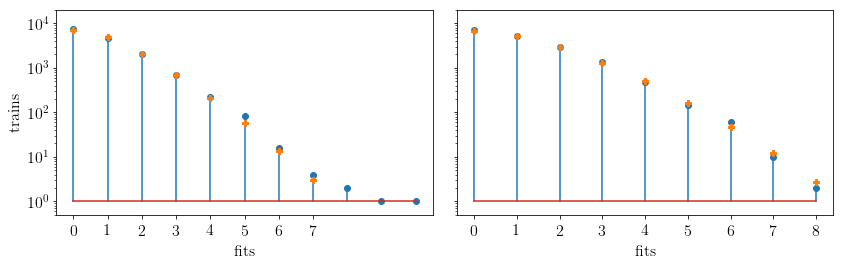

In [11]:
# distribution of fit conuts in a train
mu, n, p = fits.get_ntrains_by_nfit()
grps = np.array(fits.grps)

fig = plt.figure(figsize=[12, 4])
gs = plt.GridSpec(1, 2)

# 3rd shift
k = grps < 2

ax = plt.subplot(gs[0, 0])
fits.plot_ntrains_by_nfit(mu[k], n[k,:], p[k,:], ax=ax)
ax.set_ylim(0.5, 2e4)
ax.set_xlabel("fits")
ax.set_ylabel("trains")

# 4th shift
k = grps >= 2

ax = plt.subplot(gs[0, 1])
fits.plot_ntrains_by_nfit(mu[k], n[k,:], p[k,:], ax=ax)
ax.set_ylim(0.5, 2e4)
ax.tick_params(labelleft=False)
ax.set_xlabel("fits")

plt.tight_layout()
fig.savefig("fig_fits_6.png", dpi=300)
plt.show()


In [12]:
# correlation of the parameters (R, I, x, y) reconstructed from diffraction in two successive pulses
print(" "*9+'\tI0\tR\tx\ty')
k = fits.get_consiquent_fits()

ki = k[fits.grp[k] < 2]
C = fits.corrcoef(fits.P[ki,:].T, fits.P[ki+1,:].T)
D = np.diag(C)
print("3rd shift", end='')
for j in range(4):
    print("\t{:.2g}".format(D[j+1]), end='')
print()

ki = k[fits.grp[k] >= 2]
C = fits.corrcoef(fits.P[ki,:].T, fits.P[ki+1,:].T)
D = np.diag(C)
print("4th shift", end='')
for j in range(4):
    print("\t{:.2g}".format(D[j+1]), end='')
print()


         	I0	R	x	y
3rd shift	0.18	0.0077	0.047	0.011
4th shift	0.022	0.00077	0.12	-0.004


In [30]:
k, = np.where(np.logical_and(fits.run == fits.runs.index(312), np.abs(fits.P[:,3]-4500) < 200))
j = k[np.argmax(fits.P[k,2])]
fits.hit[j]


9315